Step: 0, Loss: [[1.6470847]]
Step: 1000, Loss: [[0.5324632]]
Step: 2000, Loss: [[0.5317575]]
Step: 3000, Loss: [[0.5310931]]
Step: 4000, Loss: [[0.53001946]]
Step: 5000, Loss: [[0.43882203]]
Step: 6000, Loss: [[0.53060275]]
Step: 7000, Loss: [[0.5233392]]
Step: 8000, Loss: [[0.25244316]]
Step: 9000, Loss: [[0.19209273]]
32/32 [==============================] - 0s 351us/step


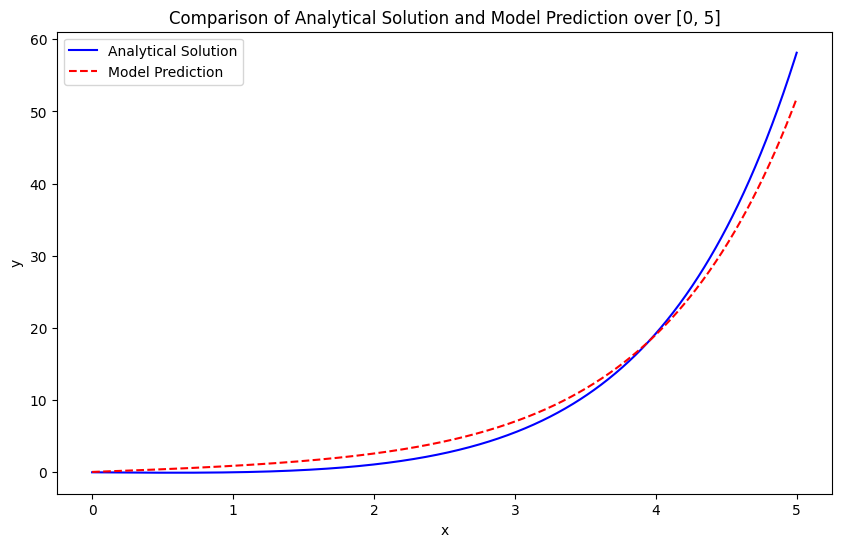

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class ODENet(tf.keras.Model):
    def __init__(self):
        super(ODENet, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='sigmoid')
        self.dense2 = tf.keras.layers.Dense(100, activation='sigmoid')
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

model = ODENet()

def loss_fn(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = model(x)
        dy_dx = tape.gradient(y, x)
    d2y_dx2 = tape.gradient(dy_dx, x)

    # Residual from the differential equation
    residual = d2y_dx2 - y

    # Calculate the loss as the squared error
    loss = tf.reduce_mean(tf.square(residual))

    # Add boundary conditions to the loss
    loss += tf.square(model(tf.constant([[0.0]], dtype=tf.float32)))
    loss += tf.square(model(tf.constant([[1.0]], dtype=tf.float32)) - 1.0)
    
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

x_samples = tf.convert_to_tensor(np.linspace(0, 5, 500).reshape(-1, 1), dtype=tf.float32)

for step in range(10000):
    loss = train_step(model, x_samples)
    if step % 1000 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")

# Define the analytical solution
def analytical_solution(t):
    e = np.exp(1)
    return (np.exp(t) - np.exp(-t) - (e - e**-1) * t) / (e - e**-1)

x_test = np.linspace(0, 5, 1000).reshape(-1, 1)
y_true = analytical_solution(x_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and Model Prediction over [0, 5]')
plt.show()



In [3]:

#y'' = y , y(0)=0, y(1)=1
